# Herramienta para el Análisis de Datos de una cuenta de Instagram
Bienvenido a la herramienta para obtener las métricas de cuentas de Instagram de negocios. En esta plataforma, podrás ejecutar el código que se conecta con Instagram directamente, que estará acompañado con una guía que llevará de la mano a quien utilice la herramienta para obtener las métricas deseadas. De tener alguna duda, revisar las preguntas frecuentes al final de la herramienta.

## ¿Qué necesito para utilizar la herramienta?
1. Una cuenta de Instagram de Empresa (es decir, con analíticas activadas)
2. Acceso a la cuenta de Facebook que está asociado al Instagram del que quieres obtener las analíticas.
3. Una aplicación en [Facebook Developers](https://developers.facebook.com/apps/).

### Pasos para utilizar la herramienta
1. Accede a la aplicación que creaste a través de https://developers.facebook.com/apps/
![](fotosHerramientaInstagram/paso8-accederALaApp.png)
2. Copia el ID de Cliente y la Llave secreta del cliente, que podrás obtener al hacer click en Configuración Básica de la aplicación que generaste en https://developers.facebook.com/apps/
![](fotosHerramientaInstagram/paso9-copiarIdYClave.png)
3. Llena los siguientes campos con los valores copiados del cliente

In [2]:
# ID DE CLIENTE
client_id = ""
# LLAVE SECRETA DEL CLIENTE
client_secret_key = ""
# EJECUTAR CON SHIFT+Enter

4. Abre la página para las [Herramientas del API de Grafo de Facebook](https://developers.facebook.com/tools/explorer)
5. Selecciona Obtener Token de Acceso de Usuario siguiendo los pasos de la foto.
![](fotosHerramientaInstagram/paso5-comienzoTokenDeAcceso.png)
6. Confirma el acceso de Facebook 
![](fotosHerramientaInstagram/paso6-confirmarAcceso.png)
7. Agrega los siguientes permisos para que la herramienta pueda utilizar acceder a la información de la cuenta de Instagram:  
    - instagram_basic
    - instagram_manage_comments
    - instagram_manage_insights
    - pages_read_engagement
    - pages_show_list
8. Genera el código (válido por 1 hora) haciendo click en Generate Access Token y acepta los permisos de Facebook.
![](fotosHerramientaInstagram/paso7-generarCodigoDeAcceso.png)
9. Copia el token de acceso y llene el siguiente campo con el código entre comillas. Habrán numerales que indicarán instrucciones dentro del código. Después, presiona SHIFT+Enter en la casilla.


In [5]:
# CÓDIGO DE ACCESO DE 1 HORA
one_hour_access_token = ""
# EJECUTAR CON SHIFT+Enter

In [6]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
import json
from datetime import datetime
import pandas as pd
import dateutil.parser as dt
from instagram_graph_api import debugAccessToken, getCreds, getInstagramBusinessAccounts, getLongLivedAccessToken, getMediaInsights, getUserInsights, getUserMedia, getUserPages
from unofficial_instagram_api import get_info_from_api as get_info_from_unofficial_api, date_validator
from instagram_internal_tool_library import display_post_info, get_hashtags, merge_apis_data

10. Prueba la conexión ejecutando la siguiente celda

In [7]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
params = getCreds(one_hour_access_token, client_id, client_secret_key)
params['debug'] = False # set debug

res_data = debugAccessToken(params)['json_data']

if('error' in res_data.keys()):
    print('Hubo un error, revisar los pasos uno a uno a partir desde el inicio.')
else:
    print('Prueba exitosa, continúa con el proceso')

Prueba exitosa, continúa con el proceso


11. Ingresa el nombre de la página de Facebook asociada con la cuenta de Instagram

In [9]:
# INGRESA EL NOMBRE DE LA PÁGINA DE FACEBOOK
page_name = ''

# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
response = getUserPages(params)
found_page = False
page_id = None
for page in response['json_data']['data']:
    if page['name'].lower().replace(" ","") == page_name.lower().replace(" ",""):
        page_id = page['id']
        found_page = True

params['page_id'] = page_id

# Nombres mas claros
if found_page == False:
    found_pages = list(map(lambda page: page['name'],response['json_data']['data']))
    print('No se consiguió ninguna página con ese nombre. Le presentamos las páginas conseguidas')
    print(found_pages)
    print('Corrija por el nombre correcto. Si no ve la página que busca, contacte con el programador: Rafael Quintero')
else:
    print('Puede continuar con el siguiente paso de la herramienta')

Puede continuar con el siguiente paso de la herramienta


12. Si después de terminar el paso 12, no hubo ningún error, introduzca el mes y el año del que se quieren obtener las métricas. Ejecuta las casillas de código

In [10]:
# Mes de Inicio (sin comillas)
start_month = 7
# Año de Inicio (sin comillas)
start_year = 2020

13. Si no quieres que las métricas lleguen hasta el día de hoy, especifica el año y mes de finalización de métricas. Al no hacerlo, se mostrarán las métricas de los post publicados desde el año y mes de inicio especificado hasta el día de hoy.

In [11]:
# Mes de Fin (sin comillas) 
end_month = datetime.now().month
# Año de Fin (sin comillas)
end_year = datetime.now().year
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
params['instagram_account_id'] = getInstagramBusinessAccounts( params )['json_data']['instagram_business_account']['id']

In [12]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
user_insights_unformatted = getUserInsights( params )['json_data']['data']
user_insights = dict()
for user_insight in user_insights_unformatted:
    user_insights[user_insight['name']] = user_insight['values'][0]['value']

In [13]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
basic_media_metrics = 'engagement,impressions,reach,saved'
params['metric'] = basic_media_metrics
# We fetch until we get all the media items needed
user_media_next_page = ''
fetched_all_media_items = False
fetched_media_items_count = 0
post_insights = list()
post_metrics_keys = []
hashtag_metrics = []
while not fetched_all_media_items:
    user_media_response = getUserMedia(params, user_media_next_page)['json_data']
    media_items = user_media_response['data']
    fetched_media_items_count += len(media_items)
    user_media_next_page = user_media_response['paging']['next']
    for index, item in enumerate(media_items, start=1):
        # We restart the params for the query
        params['metric'] = basic_media_metrics
        params['ig_media_id'] = item['id']
        # We parse the date
        date = dt.parse(item['timestamp'])
        # If the date's not valid, then we check if we at least got one before stopping
        if not date_validator(date.month, date.year, start_year, start_month, end_year, end_month):
            # If at least one item got discovered, we fetched all items
            if date.year < start_year or date.year == start_year and date.month < start_month:
                fetched_all_media_items = True
                break
            else:
                fetched_all_media_items = len(post_insights) > 1 
        # If the date is valid, we proceed normally
        elif date_validator(date.month, date.year, start_year, start_month, end_year, end_month):
            # We just add the items that meet the year and month established. We add their specific metrics
            if(item['media_type']) == 'CAROUSEL_ALBUM':
                params['metric'] += ',carousel_album_engagement,carousel_album_impressions,carousel_album_reach,carousel_album_saved,carousel_album_video_views'
            if(item['media_type']) == 'VIDEO':
                params['metric'] += ',video_views'
            insights = getMediaInsights(params)['json_data']['data']
            # We add the metrics for the item
            for insight in insights:
                if insight['name'] not in post_metrics_keys:
                    post_metrics_keys.append(insight['name'])
                item[insight['name']] = insight['values'][0]['value']
            # Adding the item to the list
            post_insights.append(item)

14. Ingresa el usuario de Instagram del que estás calculando las métricas, luego, ejecuta el código

In [14]:
# INGRESA EL NOMBRE DEL USUARIO DE INSTAGRAM
instagram_user = ""
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
unofficial_api_response = get_info_from_unofficial_api(instagram_user,fetched_media_items_count,start_year, start_month, end_year, end_month)
unofficial_posts = unofficial_api_response['medias']
unofficial_account = unofficial_api_response['account']

In [15]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
posts_info = merge_apis_data(post_insights, unofficial_posts)

In [24]:
hashtag_metrics = []
# Getting the hashtags metrics
for item in posts_info:
    post_hashtags = get_hashtags(item['caption'])
    for hashtag in post_hashtags:
        # We check if the hashtag exists
        old_existing_hashtag = next(filter(lambda ht: ht['id'] == hashtag, hashtag_metrics), None)
        if(old_existing_hashtag is not None):
            # We get its index
            hashtag_index = hashtag_metrics.index(old_existing_hashtag)
            # We update the values in a copy
            updated_existing_hashtag = old_existing_hashtag.copy()
            updated_existing_hashtag['engagement'] = old_existing_hashtag['engagement'] + item['engagement']
            updated_existing_hashtag['reach'] = old_existing_hashtag['reach'] + item['reach']
            updated_existing_hashtag['comments'] = old_existing_hashtag['comments'] + item['comments']
            updated_existing_hashtag['likes'] = old_existing_hashtag['likes'] + item['likes']
            updated_existing_hashtag['times_used'] = old_existing_hashtag['times_used'] + 1
            # We update the list item
            hashtag_metrics[hashtag_index] = updated_existing_hashtag
        else:
            # If the hashtag doesn't exist, we create it and append it
            new_hashtag_metric = dict()
            new_hashtag_metric['id'] = hashtag
            new_hashtag_metric['reach'] = item['reach']
            new_hashtag_metric['engagement'] = item['engagement']
            new_hashtag_metric['likes'] = item['likes']
            new_hashtag_metric['comments'] = item['comments']
            new_hashtag_metric['times_used'] = 1
            hashtag_metrics.append(new_hashtag_metric)

In [26]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
# Posts DataFrame Keys
post_df = pd.DataFrame()
post_basic_info_keys = ['caption','media_type','media_url','permalink','thumbnail_url','timestamp', 'likes', 'comments']
post_df_keys = post_basic_info_keys + post_metrics_keys
for key in post_df_keys:
    post_df[key] = pd.Series(list(map(lambda post: post[key] if key in post.keys() else 0, posts_info)))
# Hashtags DataFrame
hashtag_df = pd.DataFrame()
hashtag_df_keys = ['id', 'times_used']
hashtag_df_avg_keys = ['reach','engagement', 'likes','comments']
for key in hashtag_df_keys:
    hashtag_df[key] = pd.Series(list(map(lambda hashtag: hashtag[key] if key in hashtag.keys() else 0, hashtag_metrics)))
for key in hashtag_df_avg_keys:
    hashtag_df[f"avg_{key}"] = pd.Series(list(map(lambda hashtag: hashtag[key]/hashtag['times_used'] if key in hashtag.keys() else 0, hashtag_metrics)))
# Relevant Info DataFrame
relevant_info_df = pd.DataFrame()
desired_data_keys = ['comments', 'likes', 'saved', 'engagement', 'impressions', 'reach']
for key in desired_data_keys:
    relevant_info_df[f"total_{key}"] = pd.Series([post_df[key].sum()])
    relevant_info_df[f"avg_{key}"] = pd.Series([post_df[key].mean()])

15. Ejecuta para ver los mejores 5 posts

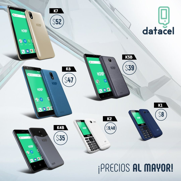

Likes: 112.
Comments: 7.
Video Views: 28.
Saved: 28.
Engagement: 147.
Impressions: 4247.
Reach: 3745.
Caption: ¿Buscas un dispositivo móvil y excelentes precios? 

En Datacel contamos con una variedad de eq...
Date: 30/7/2020
URL: IMAGE


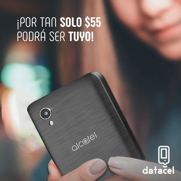

Likes: 88.
Comments: 8.
Video Views: 8.
Saved: 8.
Engagement: 104.
Impressions: 3844.
Reach: 3515.
Caption: Este espectacular equipo viene equipado con tecnología innovadora para darte soluciones al mome...
Date: 26/7/2020
URL: IMAGE


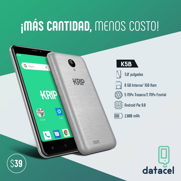

Likes: 84.
Comments: 8.
Video Views: 9.
Saved: 9.
Engagement: 101.
Impressions: 3865.
Reach: 3471.
Caption: Aprovecha esta oportunidad para tu comercio, con un precio al mayor de $39

Puedes escribirnos ...
Date: 28/7/2020
URL: IMAGE


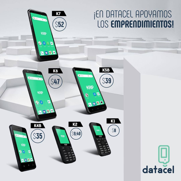

Likes: 63.
Comments: 17.
Video Views: 21.
Saved: 21.
Engagement: 101.
Impressions: 2303.
Reach: 2149.
Caption: Si lo que estás buscando para tu corporación son smartphones de calidad y únicos, ¡los encontra...
Date: 21/7/2020
URL: IMAGE


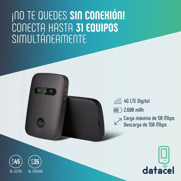

Likes: 66.
Comments: 6.
Video Views: 13.
Saved: 13.
Engagement: 85.
Impressions: 3231.
Reach: 2888.
Caption: Ahora con el JIO Router podrás conectar 31 dispositivos al mismo tiempo. La calidad, rapidez y ...
Date: 27/7/2020
URL: IMAGE


In [17]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
for row in post_df.sort_values(by=['engagement'], ascending=False).head(5).iterrows():
    display_post_info(row)

16. Ejecuta para ver los peores 5 posts según Engagement: Likes + Comments + Saves

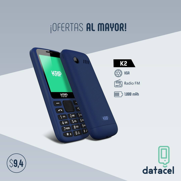

Likes: 12.
Comments: 0.
Video Views: 0.
Saved: 0.
Engagement: 12.
Impressions: 864.
Reach: 835.
Caption: El K2 es un dispositivo móvil totalmente práctico para que tu corporación este comunicada. 
...
Date: 15/7/2020
URL: IMAGE


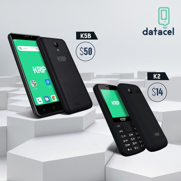

Likes: 17.
Comments: 0.
Video Views: 0.
Saved: 0.
Engagement: 17.
Impressions: 952.
Reach: 887.
Caption: Los Krip cuentan con una excelente cámara, software actualizado y pantalla de calidad. 

Te ofr...
Date: 13/7/2020
URL: IMAGE


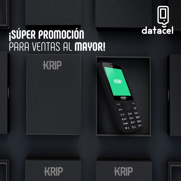

Likes: 21.
Comments: 0.
Video Views: 0.
Saved: 0.
Engagement: 21.
Impressions: 870.
Reach: 817.
Caption: ¡Krip K2, lo que necesita tu empresa!

Un precio accesible a partir de $8,90 para que todo tu e...
Date: 2/7/2020
URL: IMAGE


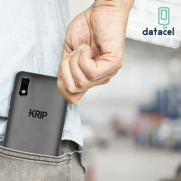

Likes: 22.
Comments: 0.
Video Views: 2.
Saved: 2.
Engagement: 24.
Impressions: 890.
Reach: 831.
Caption: El krip K4b es un equipo móvil que posee una cámara frontal de 2MPx y principal de 5MPx con u...
Date: 9/7/2020
URL: IMAGE


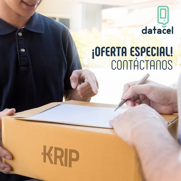

Likes: 26.
Comments: 0.
Video Views: 0.
Saved: 0.
Engagement: 26.
Impressions: 1095.
Reach: 1014.
Caption: El Krip K2 es un dispositivo  útil para siempre estar comunicado. 

Características:

-Dual SIM...
Date: 5/7/2020
URL: IMAGE


In [18]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
for row in post_df.sort_values(by=['engagement'], ascending=True).head(5).iterrows():
    display_post_info(row)

17. Guarda el Archivo Excel

In [27]:
# NO EDITAR, SOLO EJECUTAR CON SHIFT+Enter
date = f"{datetime.now().day}-{datetime.now().month}-{datetime.now().year}"
file_name = f'metricas_{instagram_user}_{date}'
with pd.ExcelWriter(f"{file_name}.xlsx") as writer:
    post_df.to_excel(writer, sheet_name='Posts')
    hashtag_df.to_excel(writer, sheet_name='Hashtags')
    relevant_info_df.to_excel(writer, sheet_name='Relevant Info')

## Posibles preguntas sobre la Herramienta

### ¿Cómo me registro en Facebook Developers y creo mi aplicación?
1. Haz click en Empezar 
![](fotosHerramientaInstagram/paso0-iniciarRegistro.png)
2. Verifica que la información en pantalla es la de la cuenta de Facebook asociada al instagram del que quieres obtener las métricas. Luego, haz click en Siguiente.
![](fotosHerramientaInstagram/paso1-aceptarFB.png)
3. Rellena cómo usarás la plataforma. En nuestro caso "Anunciante o Especialista de Marketing"
![](fotosHerramientaInstagram/paso2-informacionSobreUso.png)
4. Continúa el proceso. Haz click en Crear Primera App
![](fotosHerramientaInstagram/paso3-crearApp.png)
5. Rellena la información del formulario y haz click en Crear Identificador de la App.
![](fotosHerramientaInstagram/paso4-informacionApp.png)

### ¿Qué hago si mi cuenta de Instagram no tiene un Facebook asociado?
Si tu cuenta de Instagram no está enlazada con una cuenta de Facebook, deberás seguir los siguientes pasos para vincularla.
![](fotosHerramientaInstagram/vincularFB.png)
### ¿Qué hago si mi cuenta de Instagram tiene un Facebook que no quiero que esté asociado?
Si tu cuenta de Instagram no está enlazada con la cuenta de Facebook que quieres, deberás seguir los siguientes pasos para desvincularlas.
![](fotosHerramientaInstagram/desvincularFB.png)